In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/flood-area-segmentation/metadata.csv
/kaggle/input/flood-area-segmentation/Mask/1017.png
/kaggle/input/flood-area-segmentation/Mask/2015.png
/kaggle/input/flood-area-segmentation/Mask/1084.png
/kaggle/input/flood-area-segmentation/Mask/2021.png
/kaggle/input/flood-area-segmentation/Mask/1012.png
/kaggle/input/flood-area-segmentation/Mask/48.png
/kaggle/input/flood-area-segmentation/Mask/3012.png
/kaggle/input/flood-area-segmentation/Mask/1037.png
/kaggle/input/flood-area-segmentation/Mask/2009.png
/kaggle/input/flood-area-segmentation/Mask/1023.png
/kaggle/input/flood-area-segmentation/Mask/3070.png
/kaggle/input/flood-area-segmentation/Mask/37.png
/kaggle/input/flood-area-segmentation/Mask/1048.png
/kaggle/input/flood-area-segmentation/Mask/3068.png
/kaggle/input/flood-area-segmentation/Mask/1000.png
/kaggle/input/flood-area-segmentation/Mask/35.png
/kaggle/input/flood-area-segmentation/Mask/2030.png
/kaggle/input/flood-area-segmentation/Mask/1081.png
/kaggle/input/flood

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf

2025-10-03 12:37:24.651267: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759495044.878482      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759495044.943535      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
df = pd.read_csv('/kaggle/input/flood-area-segmentation/metadata.csv')
df.head()

,Image,Mask
0,0.jpg,0.png
1,1.jpg,1.png
2,2.jpg,2.png
3,3.jpg,3.png
4,4.jpg,4.png


In [5]:
df.columns

Index(['Image', 'Mask'], dtype='object')

In [6]:
# Paths
image_dir = '/kaggle/input/flood-area-segmentation/Image'
mask_dir = '/kaggle/input/flood-area-segmentation/Mask'

# Use a common base name
base_filename = '2021'  # found in both image and mask folders

# Full paths
image_path = os.path.join(image_dir, base_filename + '.jpg')
mask_path = os.path.join(mask_dir, base_filename + '.png')

# Read image and mask
img = cv2.imread(image_path)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

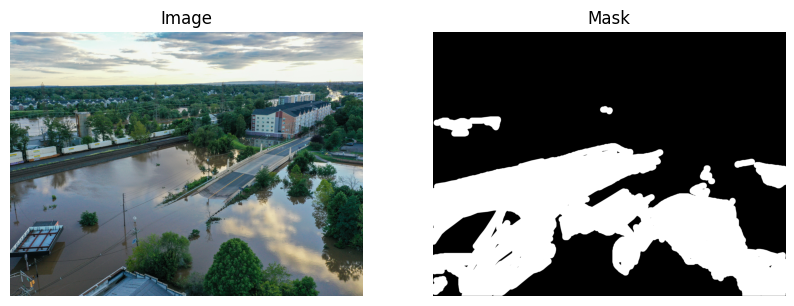

In [7]:
# Plot side-by-side
plt.figure(figsize=(10, 4))
    
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Image")
plt.axis('off')
    
plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title("Mask")
plt.axis('off')
    
plt.show()

In [8]:
# Set path and image size
IMG_PATH = '/kaggle/input/flood-area-segmentation/Image'
MASK_PATH = '/kaggle/input/flood-area-segmentation/Mask'
IMG_SIZE = 128

# List image and mask files
image_files = sorted(os.listdir(IMG_PATH))
mask_files = sorted(os.listdir(MASK_PATH))

# Find common base filenames (e.g., '2021')
image_basenames = set([f.split('.')[0] for f in image_files])
mask_basenames = set([f.split('.')[0] for f in mask_files])
common_basenames = sorted(list(image_basenames & mask_basenames))



# Load and preprocess
X, Y = [], []

for name in common_basenames:
    img = cv2.imread(f"{IMG_PATH}/{name}.jpg")
    mask = cv2.imread(f"{MASK_PATH}/{name}.png", 0)  # grayscale

    if img is not None and mask is not None:
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) / 255.0
        mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE)) / 255.0

        X.append(img)
        Y.append(mask)

In [9]:
# Convert to arrays
X = np.array(X)
Y = np.array(Y).reshape(-1, IMG_SIZE, IMG_SIZE, 1)

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

In [11]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(128,128,3)),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    tf.keras.layers.UpSampling2D(),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.UpSampling2D(),

    tf.keras.layers.Conv2D(1, (1,1), activation='sigmoid', padding='same')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

2025-10-03 12:37:51.532632: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 1)    │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 167,105 (652.75 KB)

 Trainable params: 167,105 (652.75 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
history = model.fit(X_train, Y_train, validation_split=0.1, epochs=10, batch_size=16)

Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 715ms/step - accuracy: 0.5748 - loss: 0.6513 - val_accuracy: 0.7445 - val_loss: 0.5251
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 680ms/step - accuracy: 0.7628 - loss: 0.5034 - val_accuracy: 0.7844 - val_loss: 0.4659
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 703ms/step - accuracy: 0.7798 - loss: 0.4622 - val_accuracy: 0.8001 - val_loss: 0.4418
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 671ms/step - accuracy: 0.7781 - loss: 0.4573 - val_accuracy: 0.7913 - val_loss: 0.4632
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 689ms/step - accuracy: 0.7877 - loss: 0.4385 - val_accuracy: 0.8101 - val_loss: 0.4149
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 668ms/step - accuracy: 0.7989 - loss: 0.4237 - val_accuracy: 0.7911 - val_loss: 0.4226
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 690ms/step - accuracy: 0.8028 - loss: 0.4323 - val_accuracy: 0.8139 - val_loss: 0.4007
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 670ms/step - accuracy: 0.8024 - loss: 0.4128 - val_accu

In [13]:
# Predict on test set
preds = model.predict(X_test)
preds = (preds > 0.5).astype(np.uint8)

# Check accuracy on test
loss, acc = model.evaluate(X_test, Y_test)
print("Test Accuracy:", acc)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 0.8148 - loss: 0.3872
Test Accuracy: 0.8148466944694519


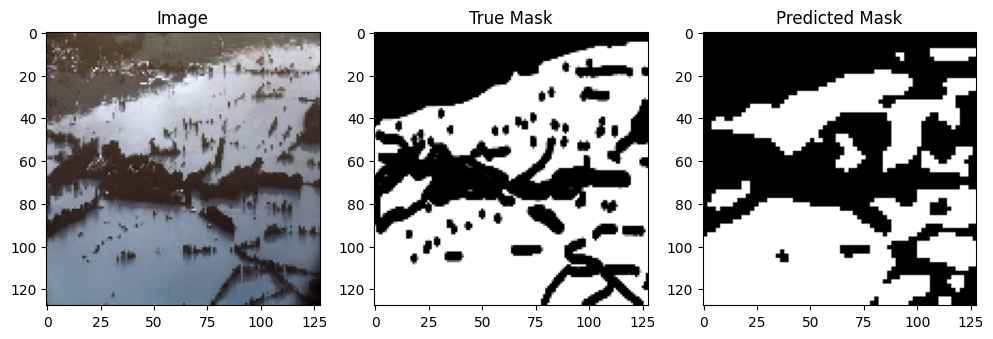

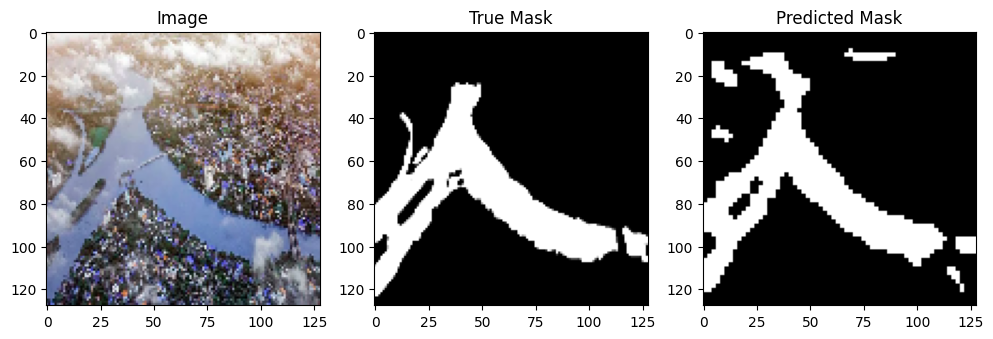

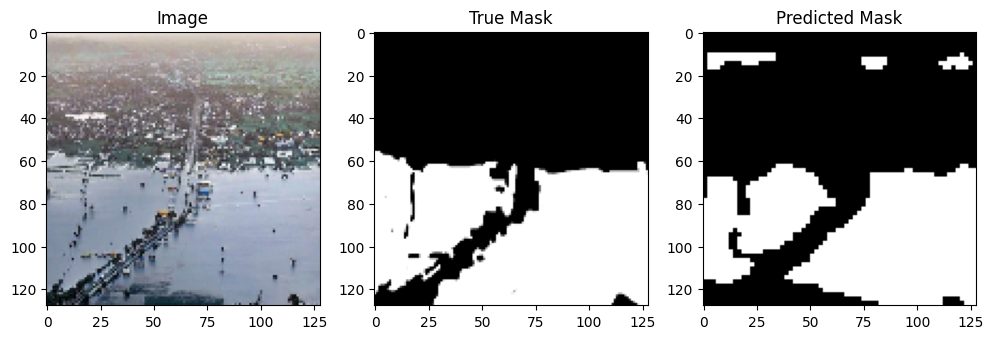

In [14]:
# Show some predictions
for i in range(3):
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.imshow(X_test[i]); plt.title("Image")
    plt.subplot(1,3,2); plt.imshow(Y_test[i].squeeze(), cmap='gray'); plt.title("True Mask")
    plt.subplot(1,3,3); plt.imshow(preds[i].squeeze(), cmap='gray'); plt.title("Predicted Mask")
    plt.show()